# Set-up Libraries

In [2]:
!pip install optuna xgboost lightgbm catboost

In [2]:
import os, joblib
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import xgboost as xgb
from os.path import join
from scipy.ndimage import label
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define Variables

In [ ]:
main_dir = r"/anvil/projects/x-cis250634/team2/Final_Data"
model_dir = r"/anvil/projects/x-cis250634/team2/Final_code_and_model"
raw_dir = join(main_dir, "Raw_Data")
rol_dir = join(main_dir, "Rolling_Data")
emb_dir = join(main_dir, "Embedding")
daily_dir = join(main_dir, "Daily")
train_dir = join(main_dir, "Training")
test_doys = [166, 167, 168, 169, 170]

# Data Reading

In [5]:
data = pd.read_parquet(join(train_dir, "training_whole.parquet"))
data = data[~data.index.get_level_values("doy").isin(test_doys)]
basic_cols = ['lon', 'lat', 'land_cover', 'dem', 't2m', 'd2m', 'u10', 'v10', 'tp', 'swvl1', 'sp']
burn_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
embed_cols = data.columns[data.columns.str.contains("band|embed")].to_list()
target = "burn"

# Split Data

In [ ]:
cols = basic_cols+burn_cols
X = data[cols]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# XGBoost Model Optimization

In [22]:
class ModelOptimizer:
    def __init__(self, X, y, cv_folds=5, random_state=42):
        """
        Initialize the model optimizer
        
        Parameters:
        X: Feature matrix
        y: Target vector
        task_type: 'classification' or 'regression'
        cv_folds: Number of cross-validation folds
        random_state: Random state for reproducibility
        """
        self.X = X
        self.y = y
        self.task_type = task_type
        self.cv_folds = cv_folds
        self.random_state = random_state
        self.cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        self.scoring = 'accuracy'
    
    def optimize_xgboost(self, n_trials=100):
        """Optimize XGBoost hyperparameters"""
        
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'random_state': self.random_state,
                'n_jobs': -1
            }
            
            if self.task_type == 'classification':
                params['objective'] = 'binary:logistic' if len(np.unique(self.y)) == 2 else 'multi:softprob'
                model = xgb.XGBClassifier(**params)
            else:
                params['objective'] = 'reg:squarederror'
                model = xgb.XGBRegressor(**params)
            
            scores = cross_val_score(model, self.X, self.y, cv=self.cv, scoring=self.scoring, n_jobs=-1)
            return scores.mean()
        
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)
        
        return study.best_params, study.best_value

classifier_optimizer = ModelOptimizer(X, y, task_type='classification')
# Optimize individual models
print("\nOptimizing XGBoost for classification...")
xgb_params, xgb_score = classifier_optimizer.optimize_xgboost(n_trials=50)

[I 2025-08-07 17:10:12,711] A new study created in memory with name: no-name-7a2dbfb0-3ac2-4f79-8bcf-deb6910b1588



Optimizing XGBoost for classification...


[I 2025-08-07 17:10:17,790] Trial 0 finished with value: 0.912434727381984 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.18348224079377773, 'subsample': 0.7438121064701262, 'colsample_bytree': 0.8777636644608691, 'reg_alpha': 8.284322880934944, 'reg_lambda': 7.780311004079676}. Best is trial 0 with value: 0.912434727381984.
[I 2025-08-07 17:10:25,586] Trial 1 finished with value: 0.9307752495330159 and parameters: {'n_estimators': 267, 'max_depth': 3, 'learning_rate': 0.09289294622380072, 'subsample': 0.9656915503601248, 'colsample_bytree': 0.9673047417395517, 'reg_alpha': 8.42147476299575, 'reg_lambda': 0.868956320894313}. Best is trial 1 with value: 0.9307752495330159.
[I 2025-08-07 17:10:44,202] Trial 2 finished with value: 0.9631865127257232 and parameters: {'n_estimators': 248, 'max_depth': 10, 'learning_rate': 0.10901184197823495, 'subsample': 0.8160079393805159, 'colsample_bytree': 0.7964620482118965, 'reg_alpha': 8.564059207518342, 'reg_lambda': 8.4752

Best XGBoost score: 0.9664
Best XGBoost params: {'n_estimators': 296, 'max_depth': 10, 'learning_rate': 0.19361383327678056, 'subsample': 0.8692095118851743, 'colsample_bytree': 0.6204181650236846, 'reg_alpha': 3.257804113500268, 'reg_lambda': 9.943986697400062}


In [80]:
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
joblib.dump(xgb_model, join(model_dir, "xgboost_model_with_burn.pkl"))

Accuracy: 0.9652069712195429
Precision: 0.9645616392341283
Recall   : 0.965900012614052
F1 Score : 0.9652303619823945


# Prediction

In [51]:
model = xgb_model
for threshold in [0.5, 0.7, 0.9, 0.95, 0.99]:
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred_thresh = (y_prob > threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print("Precision:", precision_score(y_test, y_pred_thresh))
    print("Recall   :", recall_score(y_test, y_pred_thresh))
    print("F1 Score :", f1_score(y_test, y_pred_thresh))


Threshold: 0.5
Precision: 0.9645616392341283
Recall   : 0.965900012614052
F1 Score : 0.9652303619823945

Threshold: 0.7
Precision: 0.9758197075871615
Recall   : 0.9485346676197284
F1 Score : 0.9619837530116628

Threshold: 0.9
Precision: 0.9849172511804887
Recall   : 0.9033343144262709
F1 Score : 0.9423633652074743

Threshold: 0.95
Precision: 0.9888637130598275
Recall   : 0.8624647857713493
F1 Score : 0.9213493239904774

Threshold: 0.99
Precision: 0.99404586452868
Recall   : 0.7089938191144936
F1 Score : 0.8276640651843126


In [31]:
y_pred = model.predict(X_test)
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

Precision: 0.9645616392341283
Recall   : 0.965900012614052
F1 Score : 0.9652303619823945


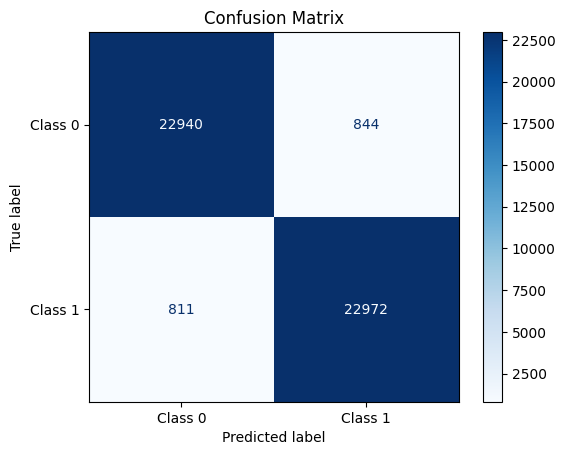

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

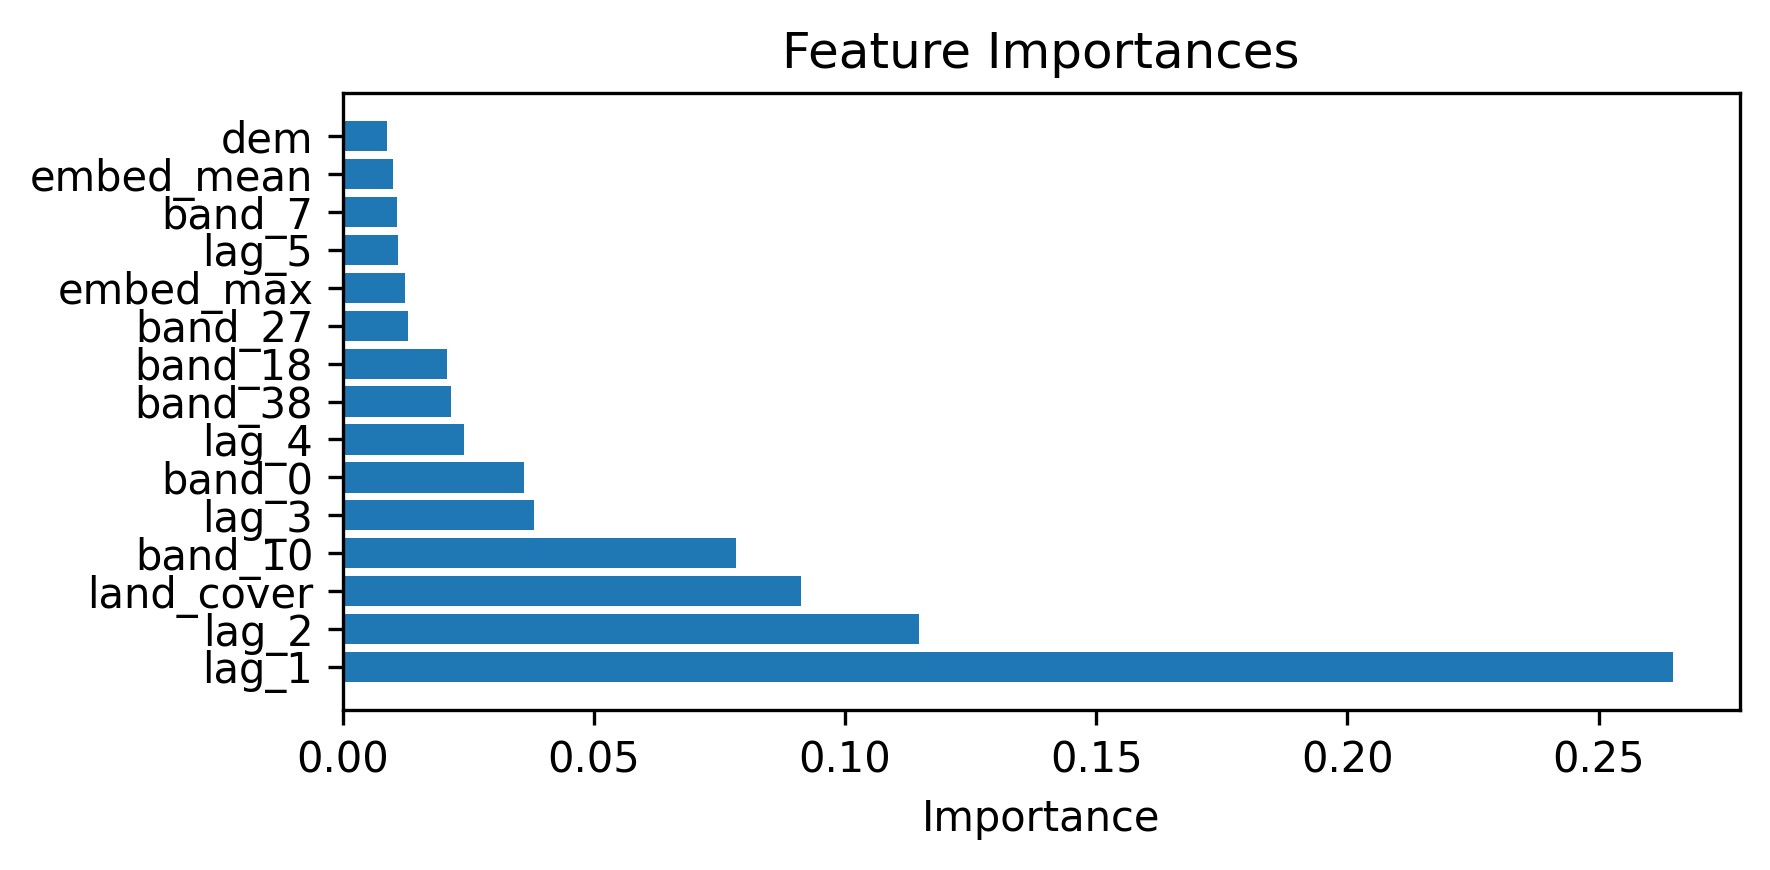

In [45]:
model = xgb_model
# Compute feature importances
# feature_importances = pd.Series(
#     model.feature_importances_,
#     index=X.columns
# ).sort_values(ascending=True)  # ascending=True for better horizontal plot

feature_imp = pd.DataFrame(data={"Features":feature_importances.index, "Importance":feature_importances.values})
feature_imp = feature_imp.sort_values("Importance", ascending=False).head(17)
feature_imp = feature_imp[~feature_imp["Features"].isin(["lat", "lon"])]

# Plot
plt.figure(figsize=(6,3),dpi=300)
plt.barh(feature_imp["Features"], feature_imp["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.savefig(fr"/anvil/projects/x-cis250634/team2/Figures/xgb_burn_embed_feature_importance.png")
plt.show()

166 6546
Accuracy: 0.9985182840945994
Precision: 0.0614115490375802
Recall: 0.17395067070532236
F1 Score: 0.09077565767189794


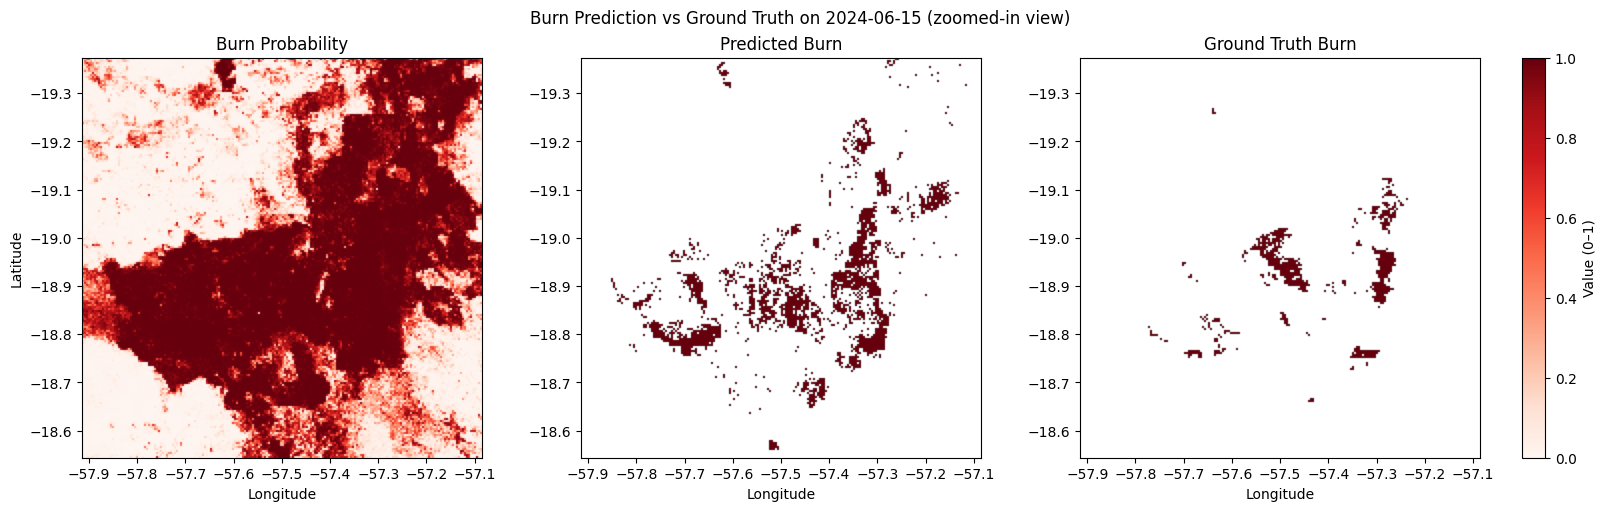

167 7399
Accuracy: 0.9985341077091362
Precision: 0.06811731315042574
Recall: 0.3197969543147208
F1 Score: 0.11231197771587743


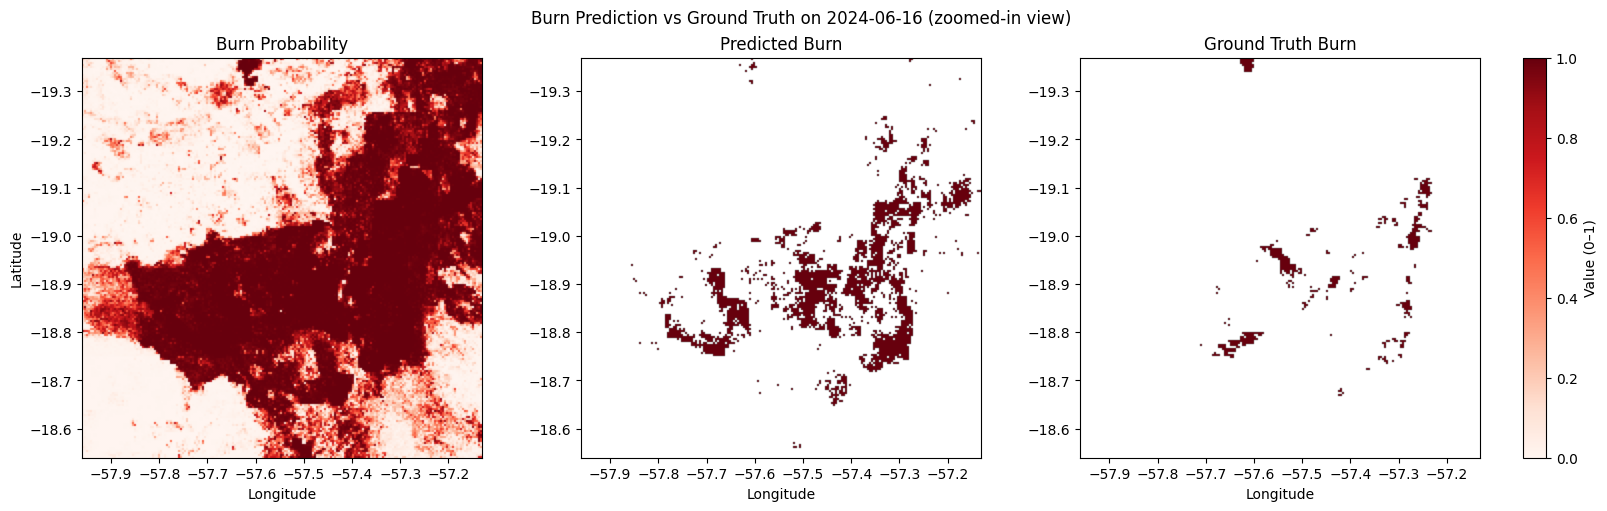

168 5856
Accuracy: 0.9987917014341531
Precision: 0.04644808743169399
Recall: 0.21673306772908366
F1 Score: 0.07650119533117705


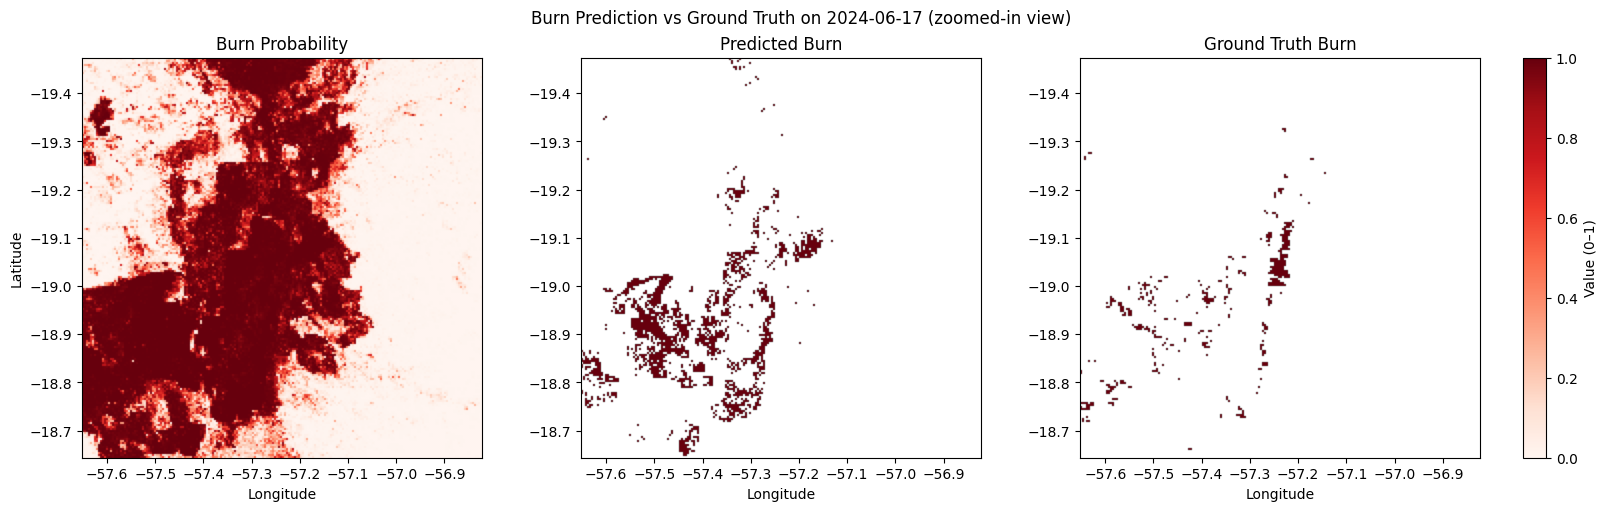

169 8866
Accuracy: 0.9982224193018658
Precision: 0.03327317843446876
Recall: 0.21299638989169675
F1 Score: 0.05755536045263877


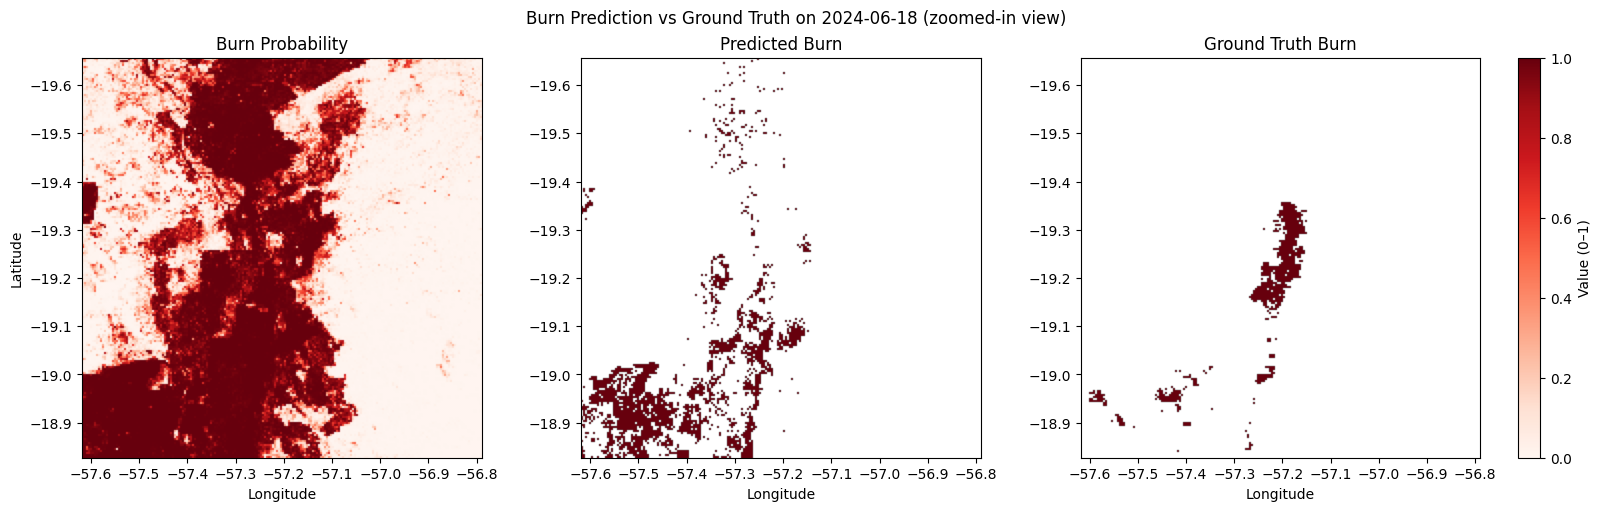

170 6036
Accuracy: 0.9987438625995071
Precision: 0.0667660702451955
Recall: 0.25234815278647466
F1 Score: 0.1055941307480676


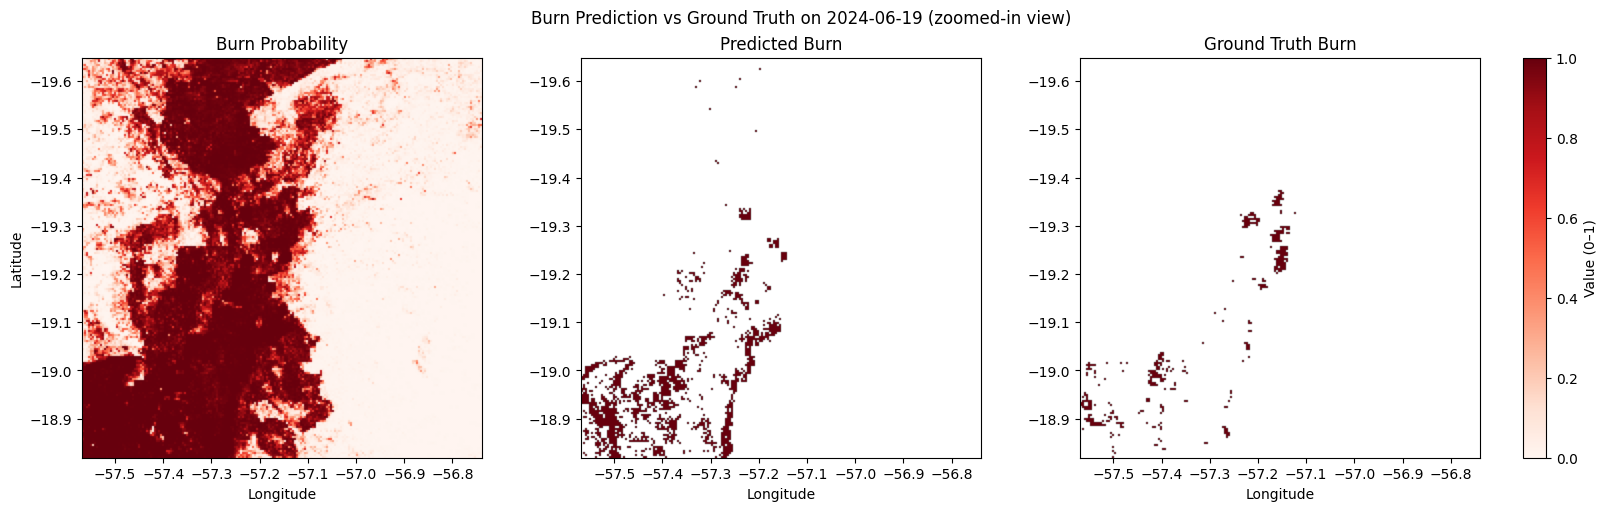

In [28]:
prob_threshold = 0.999
model = xgb_model
for doy in range(166,171):
    target_file = f"/anvil/projects/x-cis250634/team2/Final_Data/Daily/data_{doy}.parquet"
    target_date = datetime.strptime(f"{2024}-{doy+1}", "%Y-%j").date()
    
    # Read one day's data
    df_full  = pd.read_parquet(target_file)
    df_pred = df_full.copy() #.dropna(subset=x_columns + [y_column])

    X_pred = df_pred.drop(columns=[y_column, "lag_0"])
    y_true = df_pred[y_column].values

    # pred
    y_prob = model.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > prob_threshold).astype(int)

    print(doy, np.sum(y_pred))
    
    if np.sum(y_pred) > 5:    
    
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]
            
        mask = burn_true_image > prob_threshold

        # Find connected components
        structure = np.ones((3, 3))  # 8-connectivity
        labeled_array, num_features = label(mask, structure=structure)

        # Count pixels in each component
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0  # background = 0

        # Find the label of the largest component
        largest_label = sizes.argmax()

        # Mask to keep only the largest cluster
        largest_cluster_mask = labeled_array == largest_label

        # Get bounding box of this cluster
        rows, cols = np.where(largest_cluster_mask)

        center_row = int(np.mean(rows))
        center_col = int(np.mean(cols))

        crop_size = 200
        half_crop = crop_size // 2

        # Ensure the window stays within bounds
        row_min = max(center_row - half_crop, 0)
        row_max = min(center_row + half_crop, burn_prob_image.shape[0])
        col_min = max(center_col - half_crop, 0)
        col_max = min(center_col + half_crop, burn_prob_image.shape[1])

        burn_prob_crop = burn_prob_image[row_min:row_max, col_min:col_max]
        burn_pred_crop = burn_pred_image[row_min:row_max, col_min:col_max]
        burn_true_crop = burn_true_image[row_min:row_max, col_min:col_max]
        
        burn_pred_image[burn_pred_image<1] = np.nan
        burn_true_crop[burn_true_crop<1] = np.nan

        lat_crop = lats[row_min:row_max]
        lon_crop = lons[col_min:col_max]

        fig = plt.figure(figsize=(16, 5), constrained_layout=True)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

        # Create first axis normally
        axs0 = fig.add_subplot(gs[0])
        # Share y with axs0
        axs1 = fig.add_subplot(gs[1], sharey=axs0)
        axs2 = fig.add_subplot(gs[2], sharey=axs0)
        axs = [axs0, axs1, axs2]

        # Colorbar axis
        cax = fig.add_subplot(gs[3])

        vmin, vmax = 0.0, 1.0

        # Burn probability
        cmap = plt.cm.Reds
        im0 = axs[0].imshow(burn_prob_crop, cmap=cmap, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[0].set_title("Burn Probability")
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")

        # Predicted burn
        im1 = axs[1].imshow(burn_pred_crop, cmap=cmap, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[1].set_title("Predicted Burn")
        axs[1].set_xlabel("Longitude")

        # Ground truth
        im2 = axs[2].imshow(burn_true_crop, cmap=cmap, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[2].set_title("Ground Truth Burn")
        axs[2].set_xlabel("Longitude")

        # Shared colorbar
        cbar = fig.colorbar(im2, cax=cax)
        cbar.set_label("Value (0–1)")

        fig.suptitle(f"Burn Prediction vs Ground Truth on {target_date} (zoomed-in view)")
        fig.savefig(fr"/anvil/projects/x-cis250634/team2/Figures/xgb_burn_embed_{target_date.strftime("%Y-%m-%d")}.png")
        plt.show()

## Shap interpretation

In [81]:
import shap

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

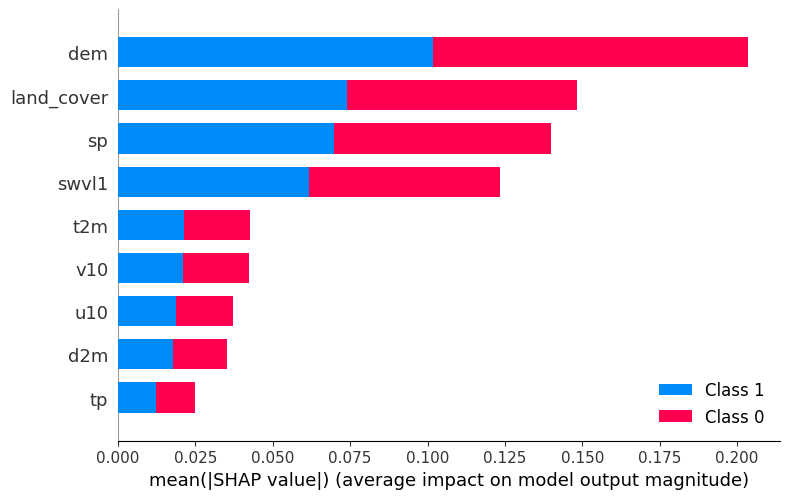

In [15]:
# feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [16]:
# single sample
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])

Dependence Plot: Nonlinear Interaction

Plotting: dem interacting with land_cover


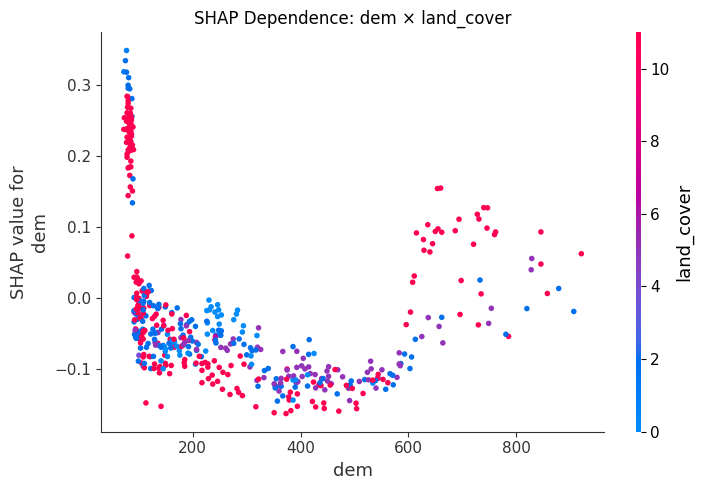

Plotting: land_cover interacting with dem


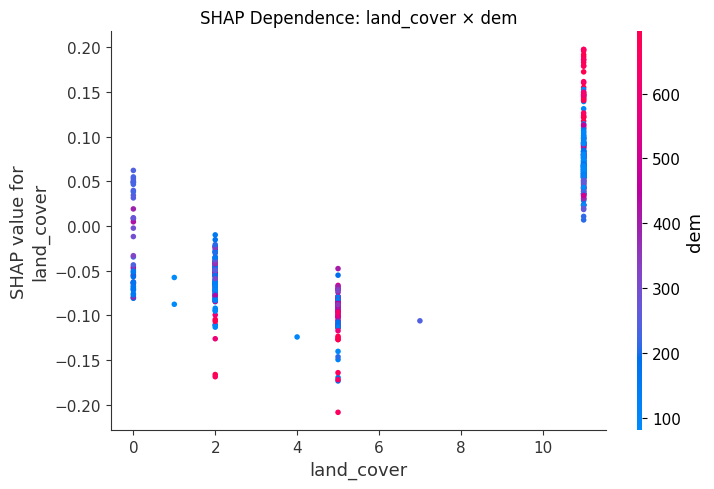

Plotting: swvl1 interacting with sp


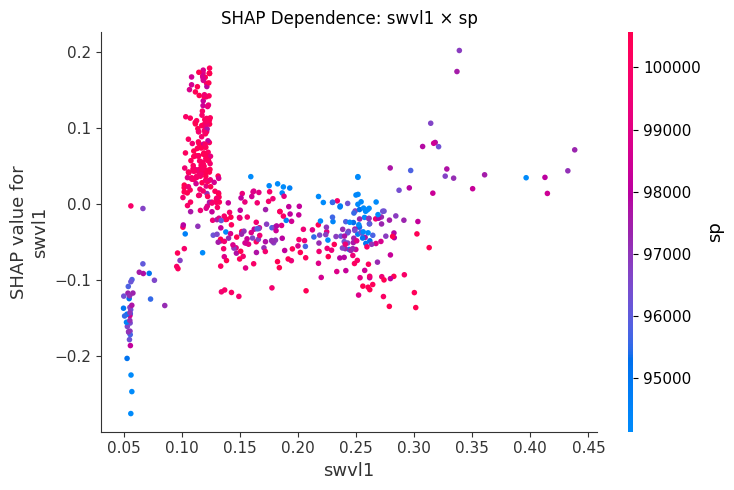

Plotting: sp interacting with swvl1


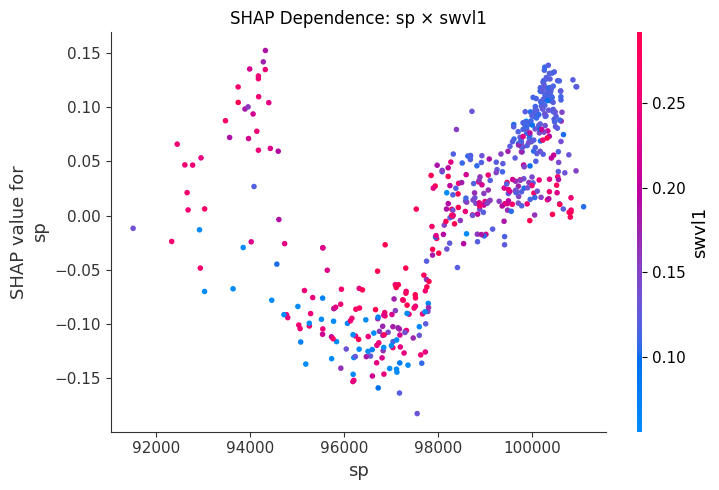

Plotting: swvl1 interacting with land_cover


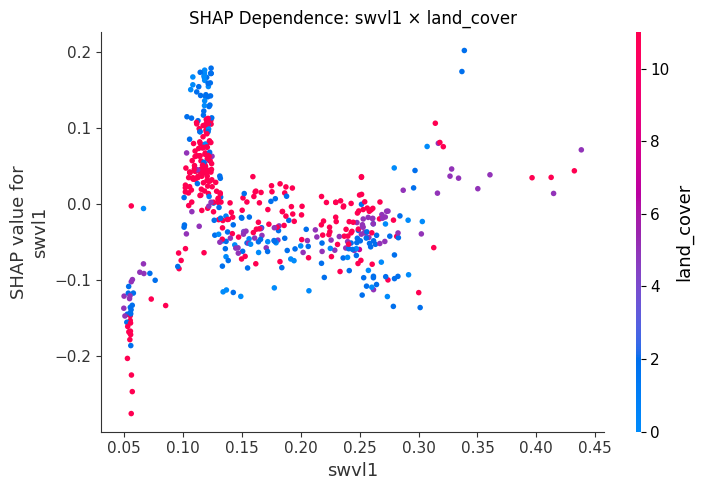

Plotting: land_cover interacting with swvl1


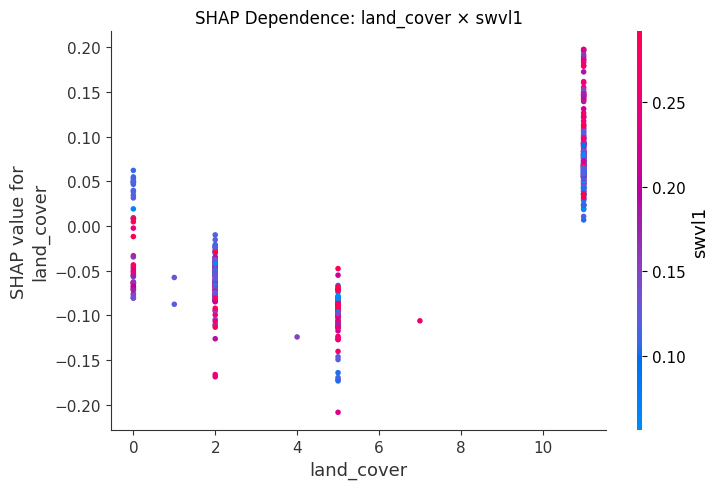

Plotting: sp interacting with land_cover


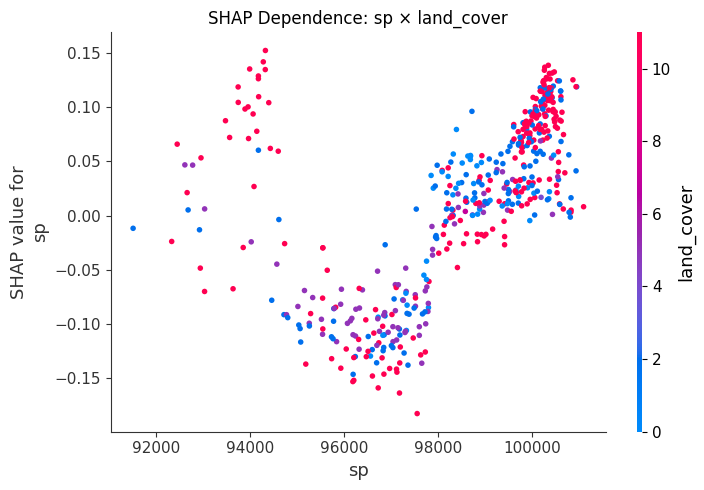

Plotting: land_cover interacting with sp


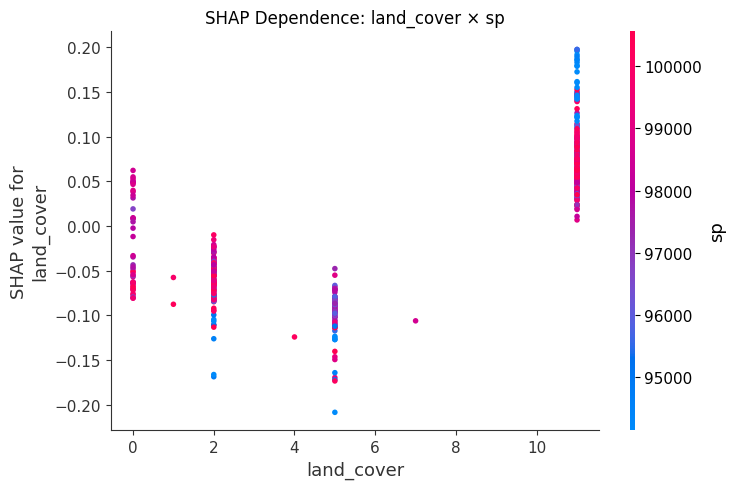

Plotting: dem interacting with swvl1


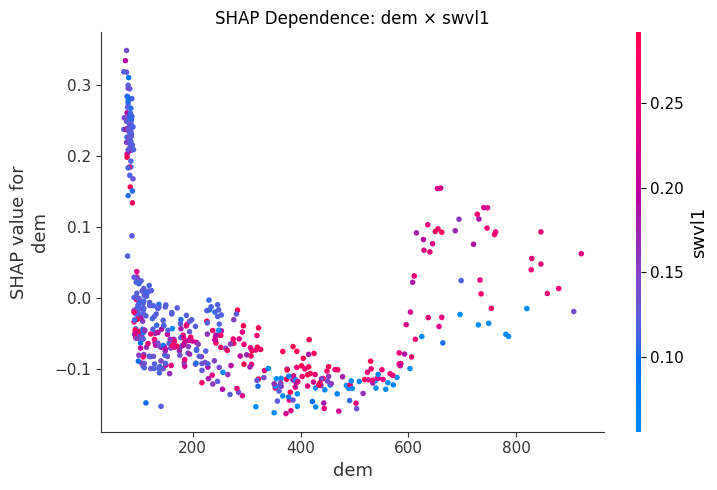

Plotting: swvl1 interacting with dem


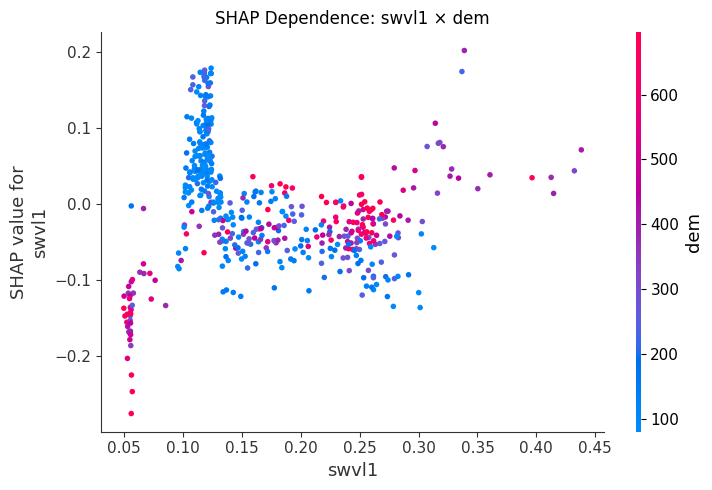

In [17]:
# Get top features
shap_values = explainer.shap_values(X_sample)
if isinstance(shap_values, list): 
    shap_values = shap_values[1]

shap_abs_mean = np.abs(shap_values).mean(axis=0)
top_k = 5
top_feat_idx = np.argsort(shap_abs_mean)[-top_k:]
top_feat_names = X_sample.columns[top_feat_idx]

# interaction values
inter_mat = explainer.shap_interaction_values(X_sample)
if isinstance(inter_mat, list):
    inter_mat = inter_mat[1]  # Use class 1 

# only top features
reduced_inter_mat = inter_mat[:, top_feat_idx, :] 

# sum interactions
interaction_strengths = np.abs(reduced_inter_mat).sum(axis=0) 

interaction_df = pd.DataFrame([
    (top_feat_names[i], X_sample.columns[j], interaction_strengths[i, j])
    for i in range(top_k) for j in range(X_sample.shape[1]) if top_feat_idx[i] != j
], columns=["Feature A", "Feature B", "Interaction Strength"])

# top interacting pairs
top_interactions = interaction_df.sort_values("Interaction Strength", ascending=False).head(10)

for _, row in top_interactions.iterrows():
    feat_a = row["Feature A"]
    feat_b = row["Feature B"]
    print(f"Plotting: {feat_a} interacting with {feat_b}")
    
    shap.dependence_plot(
        feat_a,
        shap_values,
        X_sample,
        interaction_index=feat_b,
        show=False
    )
    plt.title(f"SHAP Dependence: {feat_a} × {feat_b}")
    plt.tight_layout()
    plt.show()

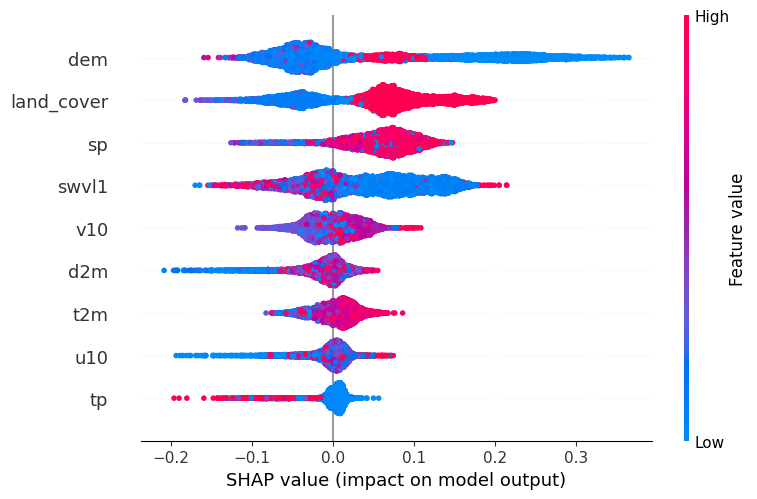

In [18]:
# Get false positives
fp_idx = (y_test == 0) & (model.predict(X_test) == 1)
X_fp = X_test[fp_idx]

# SHAP for false positives
shap_fp = explainer.shap_values(X_fp)
shap.summary_plot(shap_fp[1], X_fp, plot_type="dot")

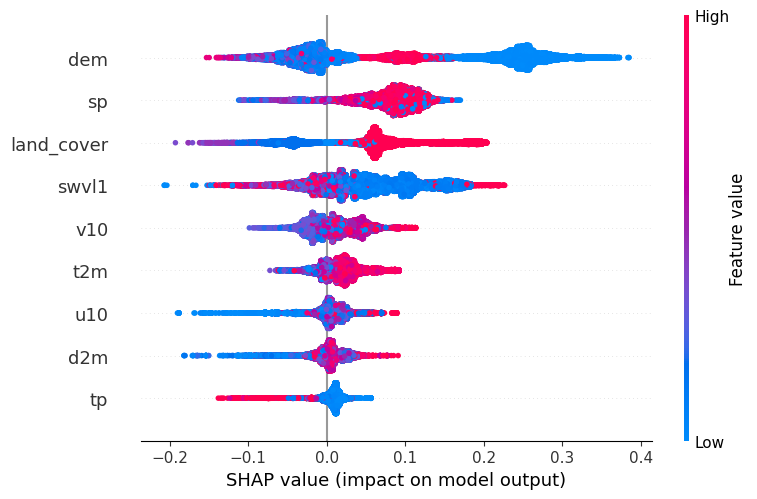

In [19]:
# Get true positives
fp_idx = (y_test == 1) & (model.predict(X_test) == 1)
X_fp = X_test[fp_idx]

# SHAP for true positives
shap_fp = explainer.shap_values(X_fp)
shap.summary_plot(shap_fp[1], X_fp, plot_type="dot")

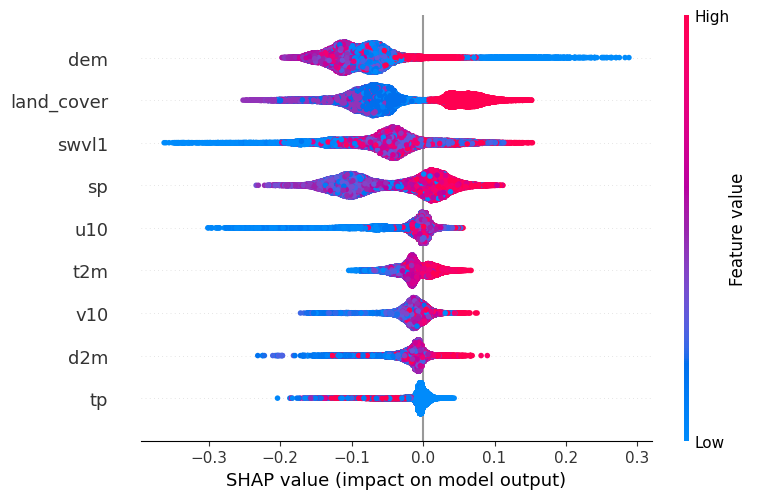

In [20]:
# Get true negatives
fp_idx = (y_test == 0) & (model.predict(X_test) == 0)
X_fp = X_test[fp_idx]

# SHAP for true negatives
shap_fp = explainer.shap_values(X_fp)
shap.summary_plot(shap_fp[1], X_fp, plot_type="dot")

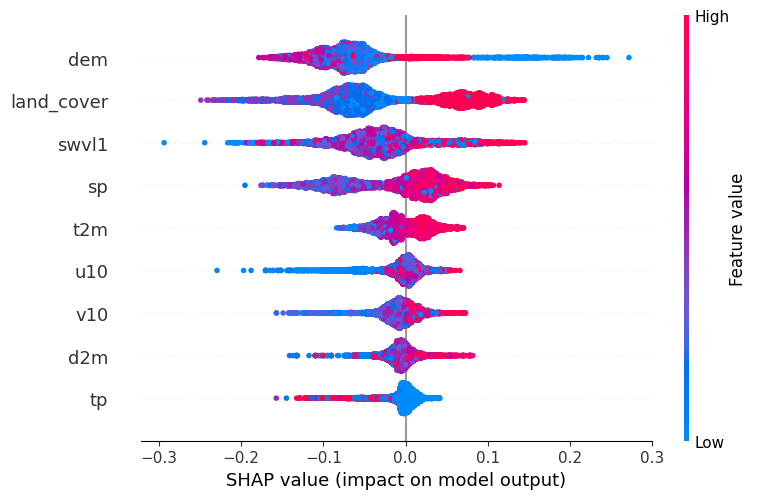

In [21]:
# Get false negatives
fp_idx = (y_test == 1) & (model.predict(X_test) == 0)
X_fp = X_test[fp_idx]

# SHAP for false negatives
shap_fp = explainer.shap_values(X_fp)
shap.summary_plot(shap_fp[1], X_fp, plot_type="dot")

SHAP Feature Interactions

In [22]:
shap_inter = explainer.shap_interaction_values(X_test)

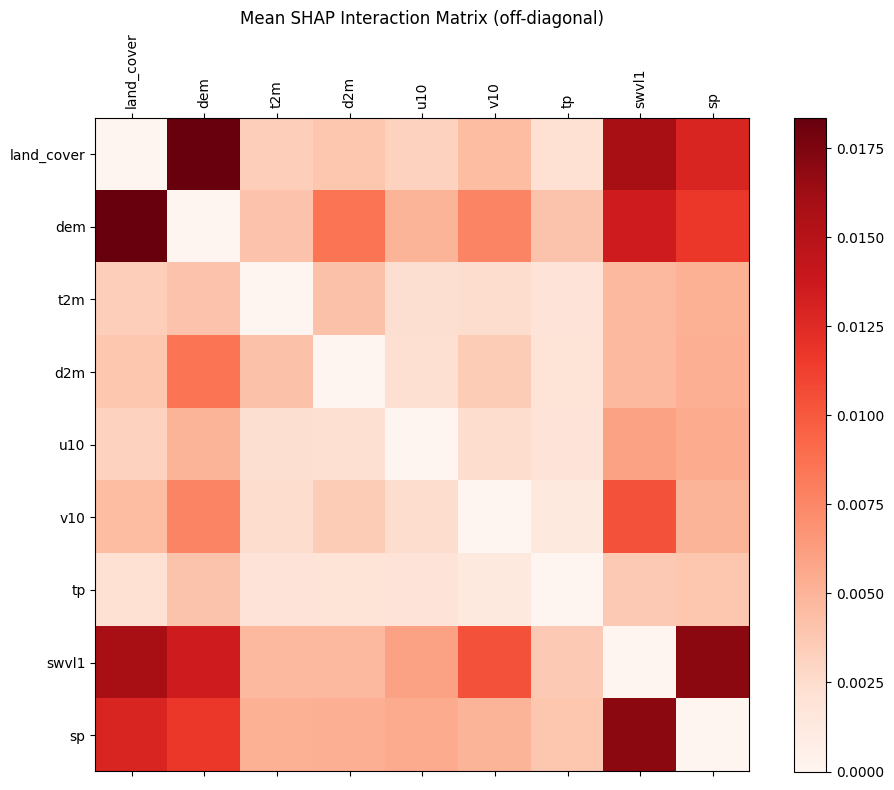

In [23]:
if isinstance(shap_inter, list): 
    shap_inter = shap_inter[1]   

# mean interaction
mean_interaction = np.abs(shap_inter).mean(axis=0)  

if mean_interaction.shape[0] == mean_interaction.shape[1]:
    np.fill_diagonal(mean_interaction, 0)
else:
    raise ValueError("Interaction matrix is not square.")

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(mean_interaction, cmap="Reds")
fig.colorbar(cax)

ax.set_xticks(range(len(X_sample.columns)))
ax.set_xticklabels(X_sample.columns, rotation=90)
ax.set_yticks(range(len(X_sample.columns)))
ax.set_yticklabels(X_sample.columns)

plt.title("Mean SHAP Interaction Matrix (off-diagonal)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"R²: {r2:.4f}")

In [ ]:
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = np.array(X_train.columns)[sorted_idx]

plt.figure(figsize=(10, 5))
plt.barh(range(len(importances)), importances[sorted_idx])
plt.yticks(range(len(importances)), sorted_features)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances (Burn Probability Regression)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [115]:
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_test)

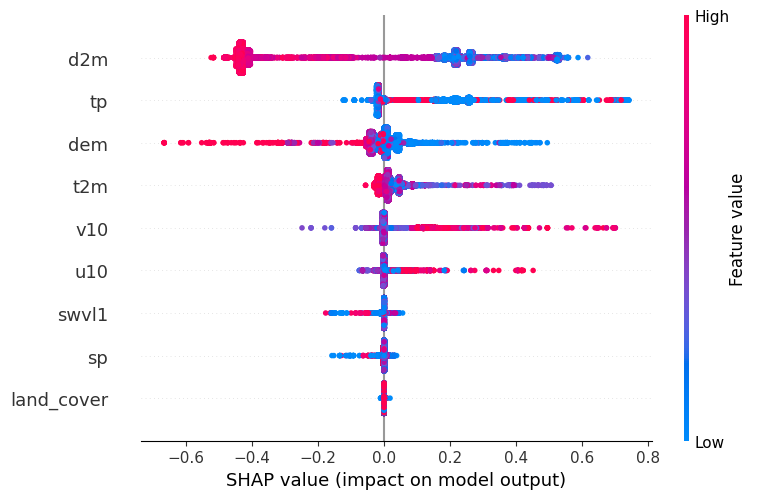

In [116]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

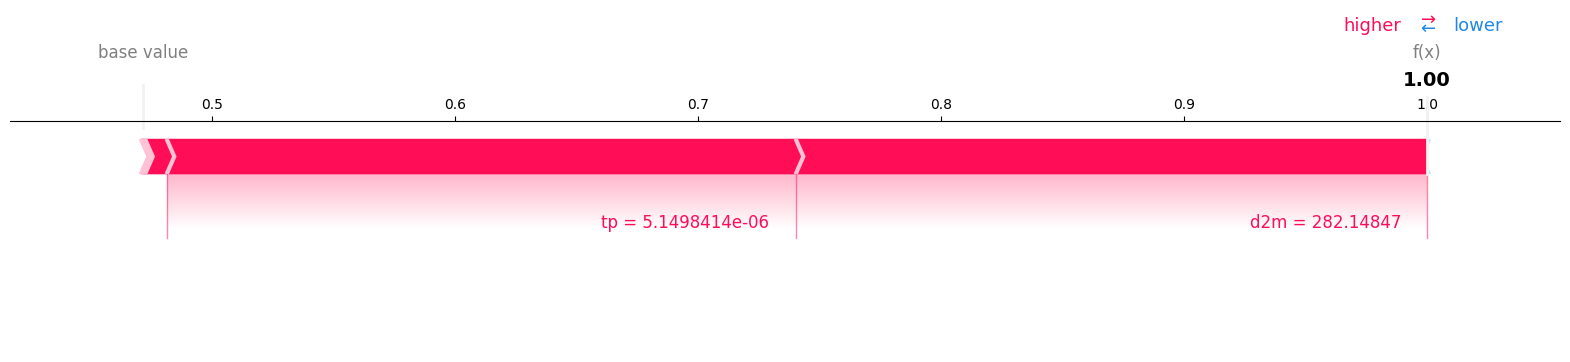

In [117]:
# Pick one test
idx = 5  
sample = X_test.iloc[idx]

# local explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[idx], sample, matplotlib=True)

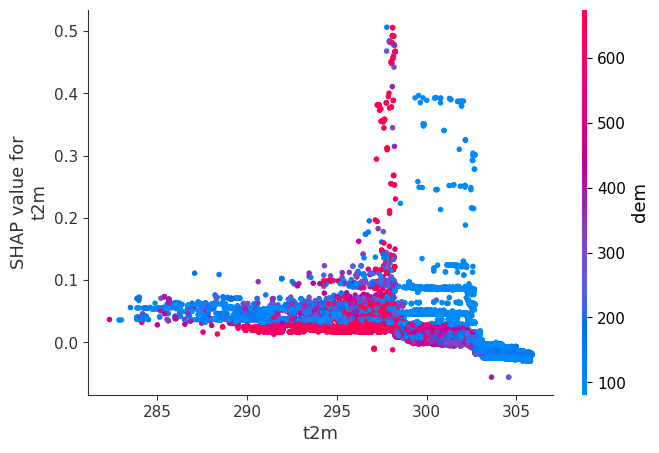

In [118]:
shap.dependence_plot("t2m", shap_values, X_test)

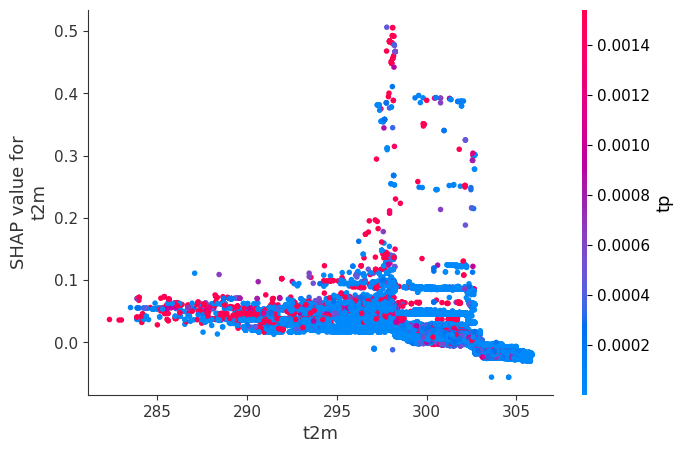

In [119]:
shap.dependence_plot("t2m", shap_values, X_test, interaction_index="tp")

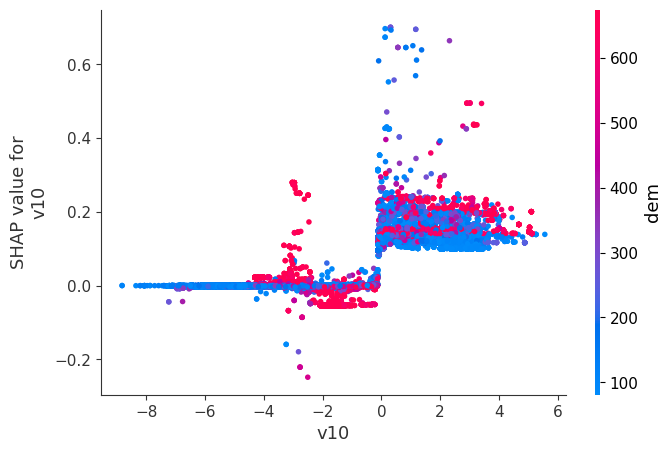

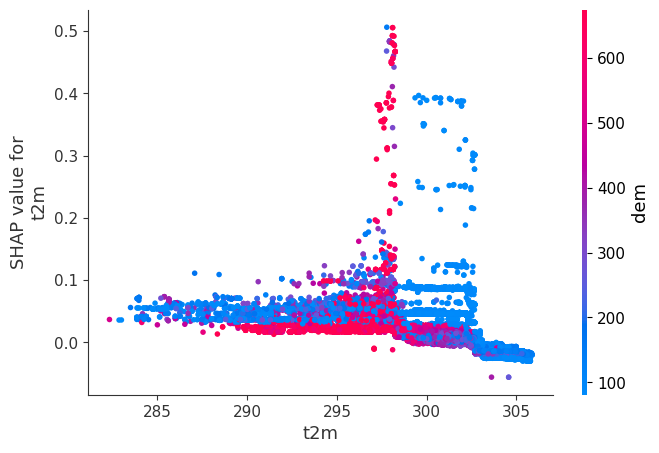

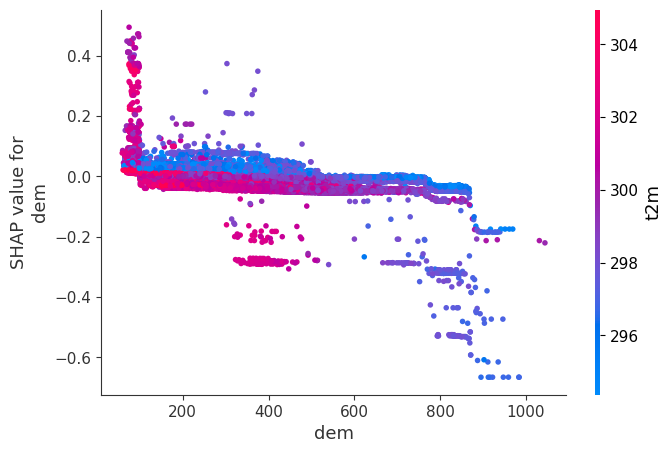

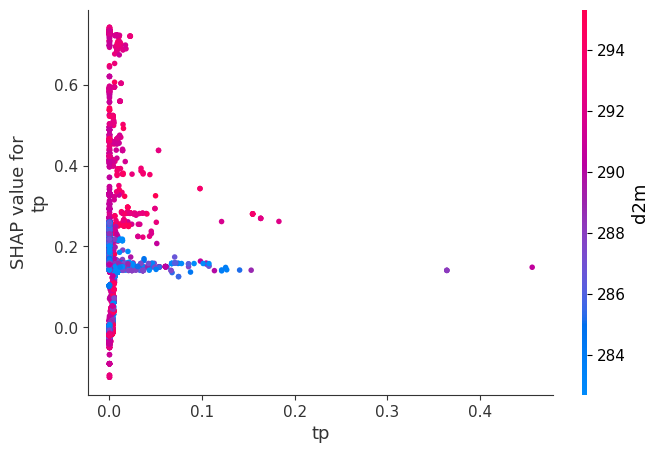

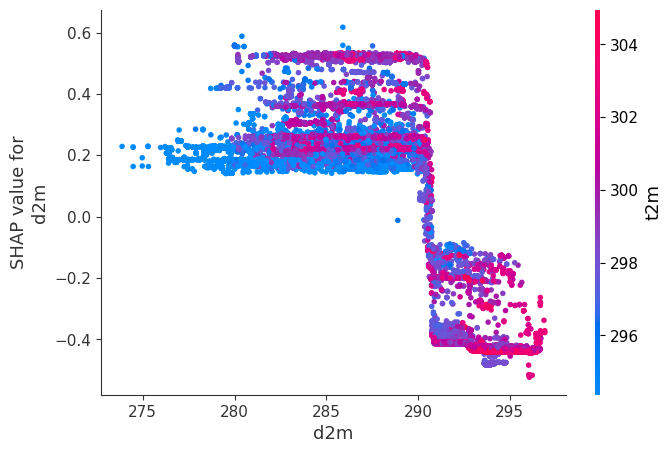

In [120]:
importances = np.abs(shap_values).mean(axis=0)
top_features = np.argsort(importances)[-5:]  # top 5 features

for idx in top_features:
    shap.dependence_plot(X_test.columns[idx], shap_values, X_test)